# Introduction to Deep Learning 
## Professor Vahid Tarokh
### Student: Ashley, John, Ryan, Julian
#### Team Project
#### Convolutional C-VAE on Fashion MNIST




##### Disclaimer: ChatGPT was used for creating the solution to the project assignment.
##### Disclaimer: Solution partly based on HW5.

In [ ]:
! pip install --upgrade torchmetrics
! pip install torch-fidelity

import numpy as np
import re
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.9 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
    # remove normalize because we want betwee 0 and 1 for loss_fn
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 12.3MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 61.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.35MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate flat size
        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, 32)
        self.label_fc = nn.Linear(32, self.flatten_size)

        # Latent
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + 32, 4 * 4 * 128)  # Fixed size for reshaping

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        c = self.label_fc(c)
        x = x + c

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c = self.label_embedding(c)
        z = torch.cat([z, c], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [ ]:
# train loop
def train(model, train_loader, optimizer, device, num_epochs):

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            recon_batch, mu, log_var = model(data, labels)

            loss = loss_function(recon_batch, data, mu, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_loss = train_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average loss = {avg_loss:.4f}')


In [ ]:
# Train model
model = ConditionalVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, optimizer, device, num_epochs=25)

Epoch 1: Average loss = 270.6195
Epoch 2: Average loss = 246.1648
Epoch 3: Average loss = 242.8962
Epoch 4: Average loss = 241.4330
Epoch 5: Average loss = 240.4099
Epoch 6: Average loss = 239.7035
Epoch 7: Average loss = 239.0964
Epoch 8: Average loss = 238.6024
Epoch 9: Average loss = 238.2517
Epoch 10: Average loss = 237.9043
Epoch 11: Average loss = 237.6052
Epoch 12: Average loss = 237.3860
Epoch 13: Average loss = 237.1758
Epoch 14: Average loss = 236.9557
Epoch 15: Average loss = 236.8174
Epoch 16: Average loss = 236.5949
Epoch 17: Average loss = 236.4851
Epoch 18: Average loss = 236.3267
Epoch 19: Average loss = 236.1628
Epoch 20: Average loss = 236.0926
Epoch 21: Average loss = 235.9886
Epoch 22: Average loss = 235.8476
Epoch 23: Average loss = 235.7814
Epoch 24: Average loss = 235.7166
Epoch 25: Average loss = 235.6373


In [ ]:
torch.save(model.state_dict(), 'conditional_vae_conv.pth')

In [ ]:
def compute_mse(model, data_loader):

    model.eval()
    mse_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, target)


            # compute the MSE for the batch
            batch_size = data.size(0)
            batch_mse = F.mse_loss(reconstructed_data, data, reduction='sum')
            mse_loss += batch_mse.item()
            total_samples += batch_size

    # compute and return the average MSE
    average_mse = mse_loss / total_samples
    return average_mse

def compute_average_ssim(model, data_loader):
    model.eval()
    total_samples = 0
    total_ssim = 0.0

    # Initialize the SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Assumes input data is in [0, 1]

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            #  process input
            reconstructed_data, _, _ = model(data, labels)

            # Reshape to image format for SSIM computation
            data = data.view(data.size(0), 1, 28, 28)  # (batch_size, channels, height, width)
            reconstructed_data = reconstructed_data.view(data.size(0), 1, 28, 28)

            # Compute SSIM for the batch
            batch_ssim = ssim(reconstructed_data, data)
            total_ssim += batch_ssim.item() * data.size(0)
            total_samples += data.size(0)

    # Compute average SSIM
    average_ssim = total_ssim / total_samples
    return average_ssim

def compute_fid(model, data_loader):
    model.eval()
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Feature layer 2048 corresponds to InceptionV3

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            reconstructed_data, _, _ = model(data, labels)

            data = data.repeat(1, 3, 1, 1)
            data = data.view(data.size(0), 3, 28, 28)
            reconstructed_data = reconstructed_data.repeat(1, 3, 1, 1)
            reconstructed_data = reconstructed_data.view(data.size(0), 3, 28, 28)

            data = (data * 255).clamp(0, 255).to(torch.uint8)
            reconstructed_data = (reconstructed_data * 255).clamp(0, 255).to(torch.uint8)


            # Add fake and real data to fid object
            fid.update(data, real=True)
            fid.update(reconstructed_data, real=False)

    fid_score = fid.compute()
    return fid_score.item()

In [ ]:
test_mse = compute_mse(model, test_loader)
print(f'Test MSE: {test_mse:.4f}')
test_ssim = compute_average_ssim(model, test_loader)
print(f'Test SSIM: {test_ssim:.4f}')
test_fid = compute_fid(model, test_loader)
print(f'Test FID: {test_fid:.4f}')

Test MSE: 11.0051
Test SSIM: 0.7644


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 94.3MB/s]


Test FID: 50.3034


In [ ]:
def sample_images(model, num_samples=4, label=None, device='cuda'):
    # Sample from model
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        # extract labels
        if label is None:
            labels = torch.arange(model.num_classes).repeat(num_samples//model.num_classes + 1)[:num_samples]
        else:
            labels = torch.full((num_samples,), label)

        labels = labels.to(device)

        # run decoder from latent space
        samples = model.decode(z, labels)
        return samples

def plot_samples(samples, title, labels=None):
    # make a 2x2 plot of samples
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        ax.imshow(samples[idx].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    #    if labels is not None:
     #       ax.set_title(f'Class {labels[idx].item()}')
    #
    plt.suptitle(f'Input: {title}')
    plt.tight_layout()
    plt.show()


# take a string and class dict, map string to proper class
# simplest encoder ever
def class_embedding(input_str, classes):
  for key in list(classes.keys()):
    template = f'(?i)\\b{key}\\b'
    output = re.search(template, input_str)
    if output: return classes[key]
  return -1


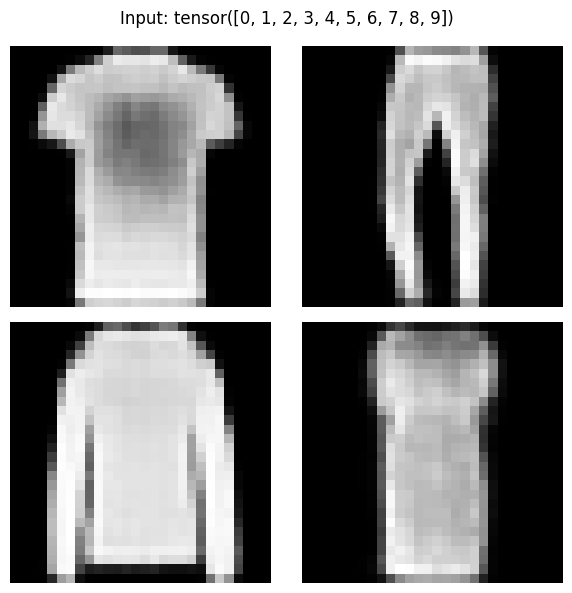

In [ ]:
# Test cVAE
#generate one sample per class:
samples = sample_images(model, num_samples=10)
plot_samples(samples, torch.arange(10))

In [ ]:
classes = {
'Shirt':0,
'Top':0,
'Trouser':1,
'Pants':1,
'Pullover':2,
'Sweater':2,
'Hoodie':2,
'Dress':3,
'Coat':4,
'Jacket':4,
'Sandal':5,
'Shirt':6,
'Sneaker':7,
'Shoe':7,
'Bag':8,
'Ankle boot':9,
'Boot':9
}

def word_to_text(input_str, classes, model, device):
  label = class_embedding(input_str, classes)
  if label == -1: return Exception("No valid label")
  samples = sample_images(model, num_samples=4, label=label, device=device)
  plot_samples(samples, input_str, torch.tensor([label]))
  return

Type Input Here: 
Make a dress


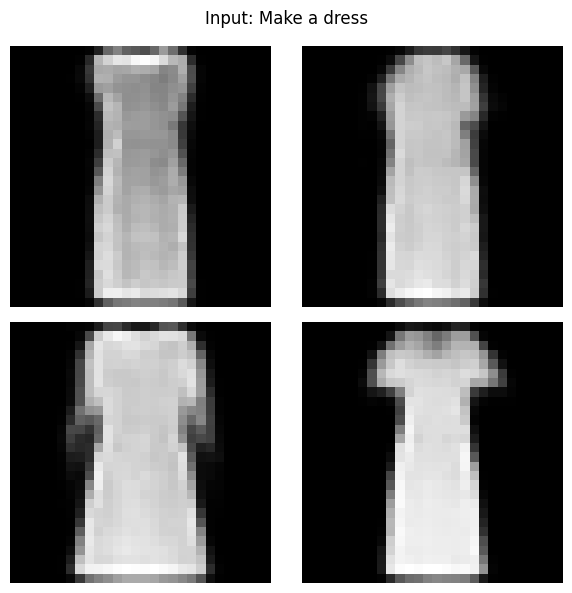

In [ ]:
print('Type Input Here: ')
input_str = input()
word_to_text(input_str, classes, model, device)

In [ ]:
from torchvision.utils import make_grid


def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20, 10))
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')

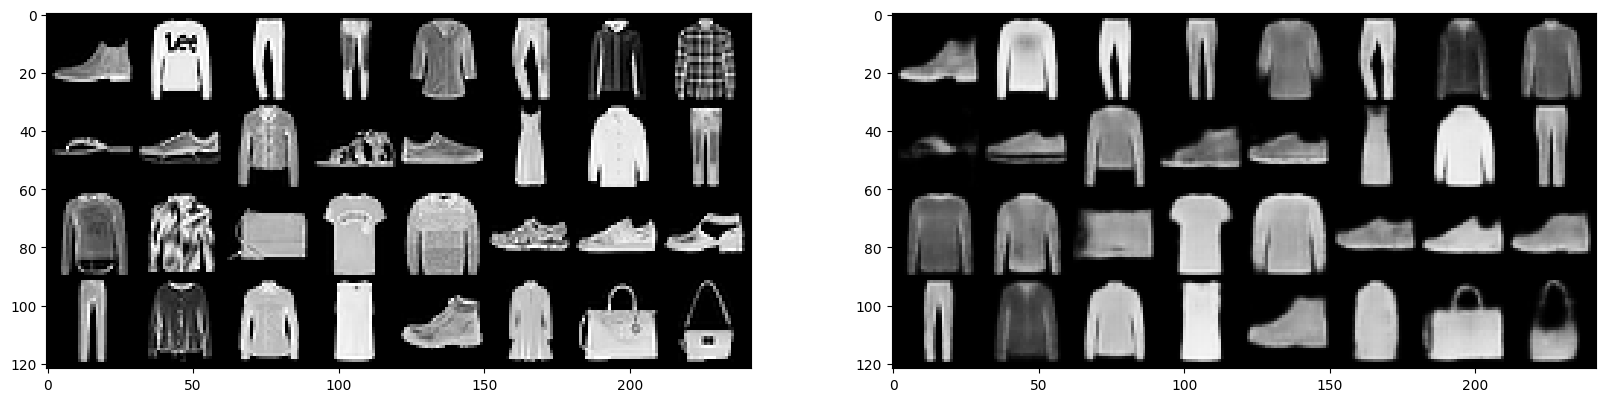

In [ ]:
# show reconstruction results
data, caption = next(iter(test_loader))
data, caption = data.to(device), caption.to(device)
reconstructed_data, _, _ = model(data, caption)

data = data[:32]
reconstructed_data = reconstructed_data[:32]

show(make_grid(data), make_grid(reconstructed_data))